# Kenya Floods in 2018

* Wenchang Yang (wenchang@princeton.edu)
* Department of Geosciences, Princeton University

In [1]:
!date
%matplotlib notebook

import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['hatch.color']='g'
import xarray as xr
import pandas as pd
import datetime

import geoxarray
from geoplots import mapplot, xticks2month

Fri May 11 11:40:18 EDT 2018


## Parameters

In [2]:
# parameters
kenya_box = dict(lon=slice(33,42),
            lat=slice(5,-5))
kenya_sbox = dict(lon=slice(37,40),
                 lat=slice(4,-2),
                 latb=slice(-2,4))
years_clim = slice('1981', '2011')

days_per_month = xr.DataArray([31,29,31,30,31,30,31,31,30,31,30,31], dims=['month'], coords=[range(1,13)])

pr_scale = 24*3600
prect_scale = 24*3600*1000

fignames = dict(climMA_1860='fig_climMA_1860.pdf',
                climMA_2000='fig_climMA_2000.pdf',
                cycle='fig_cycle.pdf', 
                cycle_sbox='fig_cycle_sbox.pdf',
                cycle_cesm='fig_cycle_cesm.pdf', 
                cycle_cesm_sbox='fig_cycle_cesm_sbox.pdf',
                accum='fig_accumulation.pdf', 
                accum_sbox='fig_accumulation_sbox.pdf',
                rmean10='fig_rollingMean10.pdf', 
                rmean10_sbox='fig_rollingMean10_sbox.pdf')

In [3]:
def eprob(da, **kws):
    '''Exceedance Probability estimation given sample da'''
    h, b = np.histogram(da, **kws)
    csum = np.cumsum(h)
    eprob = 1- csum[:-1]/csum[-1]
    return xr.DataArray(eprob, dims='b', coords=[b[1:-1],])

## Data

In [4]:
das = dict()

In [5]:
# data
# gpcc
da = xr.open_dataarray('gpcc.nc')
das['gpcc'] = da.sel(lon=kenya_box['lon'], lat=kenya_box['lat'], time=years_clim) \
    .geo.fldmean() \
    .groupby('time.month')/days_per_month # mm/month -> mm/day
    
# FLOR 1860
da = xr.open_dataarray('PIctl_CMIP6volc.precip.nc')
time = da['time'].values
time_new = [datetime.datetime(*t.replace(year=t.year+2000, day=1).timetuple()[0:6]) for t in time]
da['t'] = ('time', time_new)
das['flor_1860'] = da.set_index(time='t').sel(time=slice('2051', None)).rename(dict(grid_xt='lon', grid_yt='lat')) \
    .geo.fldmean() * pr_scale
da = da.set_index(time='t').sel(time=slice('2051', None)).rename(dict(grid_xt='lon', grid_yt='lat'))
das['flor_1860_clim'] =  da[(da['time.month']==3) | (da['time.month']==4)].mean('time')* pr_scale
    
# FLOR 2000
da = xr.open_dataarray('Control_2000.precip.nc')
time = da['time'].values
time_new = [datetime.datetime(*t.replace(year=t.year+2000, day=1).timetuple()[0:6]) for t in time]
da['t'] = ('time', time_new)
das['flor_2000'] = da.set_index(time='t').sel(time=slice('2051', None)).rename(dict(grid_xt='lon', grid_yt='lat')) \
    .geo.fldmean() * pr_scale
da = da.set_index(time='t').sel(time=slice('2051', None)).rename(dict(grid_xt='lon', grid_yt='lat'))
das['flor_2000_clim'] =  da[(da['time.month']==3) | (da['time.month']==4)].mean('time')* pr_scale

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/coding/times.py:111: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  return self.func(self.array[key])
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/coding/times.py:111: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/co

In [15]:
# data: small region
# gpcc
da = xr.open_dataarray('gpcc.nc')
das['gpcc_s'] = da.sel(lon=kenya_sbox['lon'], lat=kenya_sbox['lat'], time=years_clim) \
    .geo.fldmean() \
    .groupby('time.month')/days_per_month # mm/month -> mm/day
    
# FLOR 1860
da = xr.open_dataarray('PIctl_CMIP6volc.precip.nc')
time = da['time'].values
time_new = [datetime.datetime(*t.replace(year=t.year+2000, day=1).timetuple()[0:6]) for t in time]
da['t'] = ('time', time_new)
das['flor_1860_s'] = da.set_index(time='t').sel(time=slice('2051', None)).rename(dict(grid_xt='lon', grid_yt='lat')) \
    .sel(lon=kenya_sbox['lon'], lat=kenya_sbox['latb']).geo.fldmean() * pr_scale

# FLOR 2000
da = xr.open_dataarray('Control_2000.precip.nc')
time = da['time'].values
time_new = [datetime.datetime(*t.replace(year=t.year+2000, day=1).timetuple()[0:6]) for t in time]
da['t'] = ('time', time_new)
das['flor_2000_s'] = da.set_index(time='t').sel(time=slice('2051', None)).rename(dict(grid_xt='lon', grid_yt='lat')) \
    .sel(lon=kenya_sbox['lon'], lat=kenya_sbox['latb']).geo.fldmean() * pr_scale

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/coding/times.py:111: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  return self.func(self.array[key])
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/coding/times.py:111: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/co

In [244]:
# data: FLORish
# FLORish 1850
da = xr.open_dataset('B1850CN_f05g16_tigercpu_680PE.prect.nc')['PRECT']
time = da['time'].values
time_new = [datetime.datetime(*t.replace(year=t.year+2000, day=1).timetuple()[0:6]) for t in time]
da['t'] = ('time', time_new)
das['florish_1850'] = da.set_index(time='t').sel(time=slice('2051', None)) \
    .geo.fldmean() * prect_scale
    
# FLORish 2000
da = xr.open_dataset('BCN_f05g16_tigercpu_680PE.prect.nc')['PRECT']
time = da['time'].values
time_new = [datetime.datetime(*t.replace(year=t.year+2000, day=1).timetuple()[0:6]) for t in time]
da['t'] = ('time', time_new)
das['florish_2000'] = da.set_index(time='t').sel(time=slice('2051', None)) \
    .geo.fldmean() * prect_scale

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/coding/times.py:111: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  return self.func(self.array[key])
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/coding/times.py:111: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/co

In [240]:
# data: FLORish small region
# FLORish 1850
da = xr.open_dataset('B1850CN_f05g16_tigercpu_680PE.prect.nc')['PRECT']
time = da['time'].values
time_new = [datetime.datetime(*t.replace(year=t.year+2000, day=1).timetuple()[0:6]) for t in time]
da['t'] = ('time', time_new)
das['florish_1850_s'] = da.set_index(time='t').sel(time=slice('2051', None)) \
    .sel(lon=kenya_sbox['lon'], lat=kenya_sbox['latb']).geo.fldmean() * prect_scale
    
# FLORish 2000
da = xr.open_dataset('BCN_f05g16_tigercpu_680PE.prect.nc')['PRECT']
time = da['time'].values
time_new = [datetime.datetime(*t.replace(year=t.year+2000, day=1).timetuple()[0:6]) for t in time]
da['t'] = ('time', time_new)
das['florish_2000_s'] = da.set_index(time='t').sel(time=slice('2051', None)) \
    .sel(lon=kenya_sbox['lon'], lat=kenya_sbox['latb']).geo.fldmean() * prect_scale

/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/coding/times.py:111: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/coding/variables.py:66: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  return self.func(self.array[key])
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/coding/times.py:111: SerializationWarning: Unable to decode time axis into full numpy.datetime64 objects, continuing using dummy netcdftime.datetime objects instead, reason: dates out of range
  result = decode_cf_datetime(example_value, units, calendar)
/tigress/wenchang/miniconda3/lib/python3.6/site-packages/xarray/co

## Region box

<IPython.core.display.Javascript object>


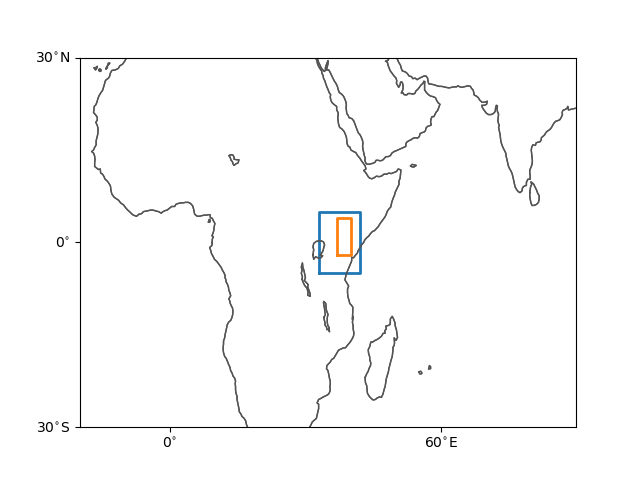

In [209]:
mapplot(lon=(-20,90), lat=(-30,30),lonlatbox=(33,42,-5,5), lonlatbox_color='C0')
mapplot(lonlatbox=(37,40,-2,4), lonlatbox_color='C1')

## Climatology

<IPython.core.display.Javascript object>


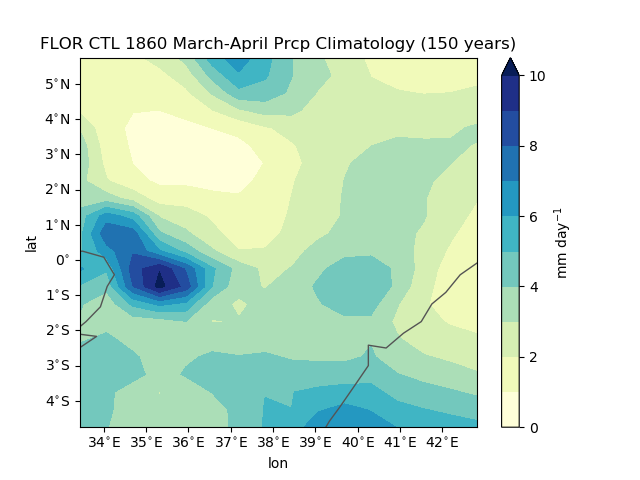

In [10]:
# plot: 1860
da = das['flor_1860_clim']
da.rename('mm day$^{-1}$').plot.contourf(levels=range(0,11), cmap='YlGnBu')

mapplot(xticks=range(34, 43), yticks=range(-5,6))
plt.title('FLOR CTL 1860 March-April Prcp Climatology (150 years)')

plt.savefig(fignames['climMA_1860'])
# da.assign_attrs(units='mm/day', long_name='precipitation').to_netcdf('FLOR_1860_prcp_climMA.nc')

<IPython.core.display.Javascript object>


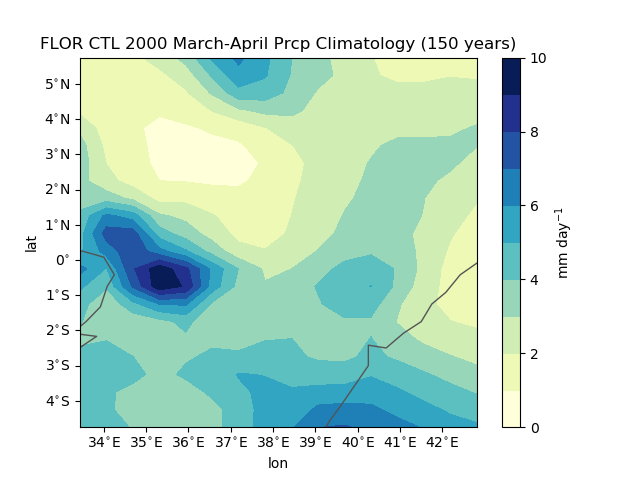

In [11]:
# plot: 2000
da = das['flor_2000_clim']
da.rename('mm day$^{-1}$').plot.contourf(levels=range(0,11), cmap='YlGnBu')

mapplot(xticks=range(34, 43), yticks=range(-5,6))
plt.title('FLOR CTL 2000 March-April Prcp Climatology (150 years)')

plt.savefig(fignames['climMA_2000'])
# da.assign_attrs(units='mm/day', long_name='precipitation').to_netcdf('FLOR_2000_prcp_climMA.nc')

## Seasonal cycle

<IPython.core.display.Javascript object>


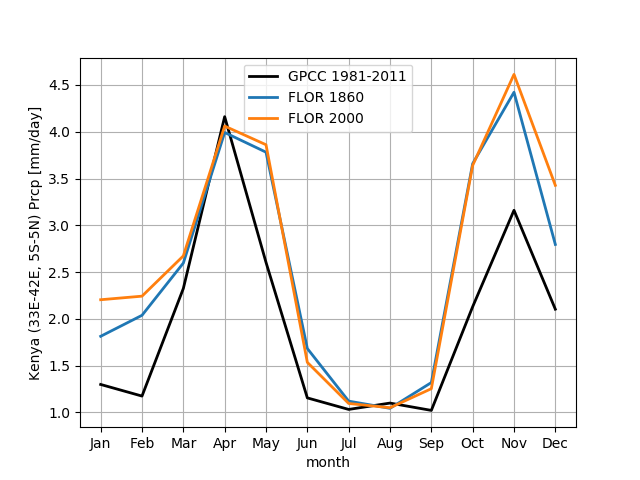

In [210]:
# plot: seasonal cycle
das['gpcc'].groupby('time.month').mean('time') \
    .plot(label='GPCC 1981-2011', color='k')
das['flor_1860'].groupby('time.month').mean('time').plot(label='FLOR 1860')
das['flor_2000'].groupby('time.month').mean('time').plot(label='FLOR 2000')

xticks2month(range(1,13))
plt.legend(frameon=True)
plt.grid(True)
plt.ylabel('Kenya (33E-42E, 5S-5N) Prcp [mm/day]')

plt.savefig(fignames['cycle'])

### CESM1.2.1

<IPython.core.display.Javascript object>


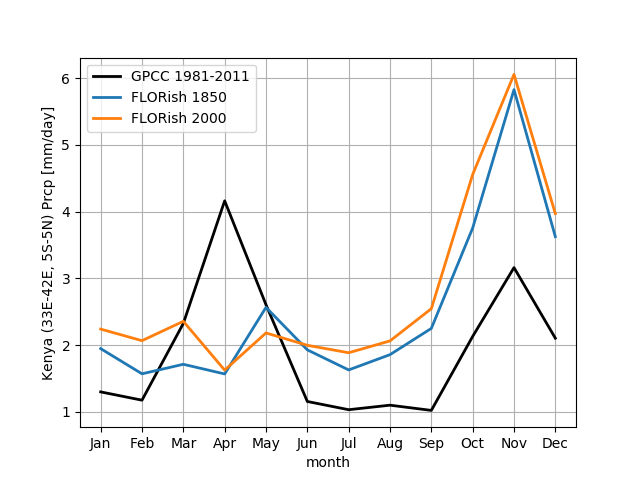

In [247]:
# plot: seasonal cycle
das['gpcc'].groupby('time.month').mean('time') \
    .plot(label='GPCC 1981-2011', color='k')
das['florish_1850'].groupby('time.month').mean('time').plot(label='FLORish 1850')
das['florish_2000'].groupby('time.month').mean('time').plot(label='FLORish 2000')

xticks2month(range(1,13))
plt.legend(frameon=True)
plt.grid(True)
plt.ylabel('Kenya (33E-42E, 5S-5N) Prcp [mm/day]')

plt.savefig(fignames['cycle_cesm'])

### small region box

<IPython.core.display.Javascript object>


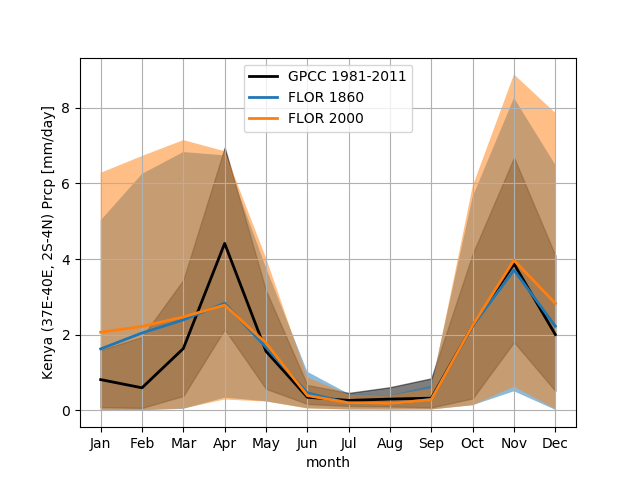

In [232]:
# plot: seasonal cycle
# das['gpcc_s'].groupby('time.month').mean('time') \
#     .plot(label='GPCC 1981-2011', color='k')

da = das['gpcc_s'].groupby('time.month')
damean = da.mean('time')
da.mean('time').plot(label='GPCC 1981-2011', color='k')
plt.fill_between(damean.month, da.reduce(np.percentile, q=10), da.reduce(np.percentile, q=90), alpha=.5, color='k')

da = das['flor_1860_s'].groupby('time.month')
damean = da.mean('time')
da.mean('time').plot(label='FLOR 1860')
plt.fill_between(damean.month, da.reduce(np.percentile, q=10), da.reduce(np.percentile, q=90), alpha=.5)

da = das['flor_2000_s'].groupby('time.month')
damean = da.mean('time')
damean.plot(label='FLOR 2000')
plt.fill_between(damean.month, da.reduce(np.percentile, q=10), da.reduce(np.percentile, q=90), alpha=.5)


xticks2month(range(1,13))
plt.legend(frameon=True, loc='upper center')
plt.grid(True)
plt.ylabel('Kenya (37E-40E, 2S-4N) Prcp [mm/day]')

plt.savefig(fignames['cycle_sbox'])

### CESM1.2.1 small region box

<IPython.core.display.Javascript object>


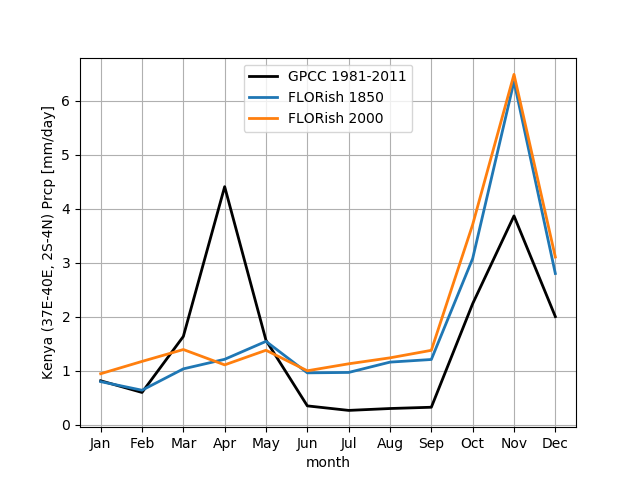

In [248]:
# plot: seasonal cycle

da = das['gpcc_s'].groupby('time.month')
damean = da.mean('time')
da.mean('time').plot(label='GPCC 1981-2011', color='k')
# plt.fill_between(damean.month, da.reduce(np.percentile, q=10), da.reduce(np.percentile, q=90), alpha=.5, color='k')

da = das['florish_1850_s'].groupby('time.month')
damean = da.mean('time')
da.mean('time').plot(label='FLORish 1850')
# plt.fill_between(damean.month, da.reduce(np.percentile, q=10), da.reduce(np.percentile, q=90), alpha=.5)

da = das['florish_2000_s'].groupby('time.month')
damean = da.mean('time')
damean.plot(label='FLORish 2000')
# plt.fill_between(damean.month, da.reduce(np.percentile, q=10), da.reduce(np.percentile, q=90), alpha=.5)


xticks2month(range(1,13))
plt.legend(frameon=True, loc='upper center')
plt.grid(True)
plt.ylabel('Kenya (37E-40E, 2S-4N) Prcp [mm/day]')

plt.savefig(fignames['cycle_cesm_sbox'])

## Accumulation 

<IPython.core.display.Javascript object>


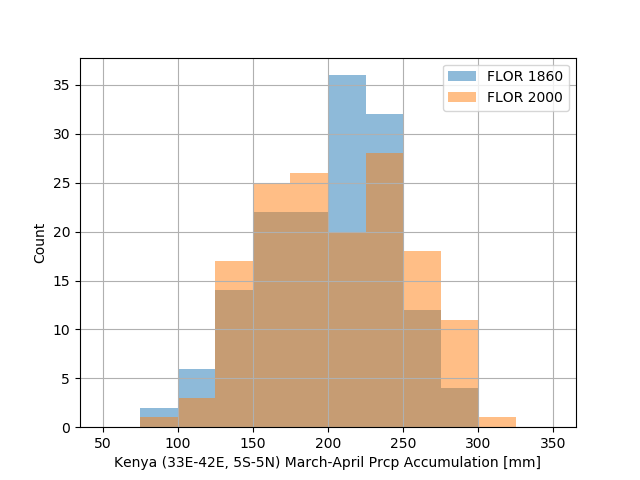

In [213]:
# plot
bins = range(50,350+1,25)
da = das['flor_1860']
da = da[(da['time.month']==3) | (da['time.month']==4)]
da.resample(time='AS').sum().plot.hist(label='FLOR 1860', bins=bins, alpha=.5)

da = das['flor_2000']
da = da[(da['time.month']==3) | (da['time.month']==4)]
da.resample(time='AS').sum().plot.hist(label='FLOR 2000', bins=bins, alpha=.5)

plt.grid(True)
plt.legend(frameon=True)
plt.xlabel('Kenya (33E-42E, 5S-5N) March-April Prcp Accumulation [mm]')
plt.savefig(fignames['accum'])

### small region box

<IPython.core.display.Javascript object>


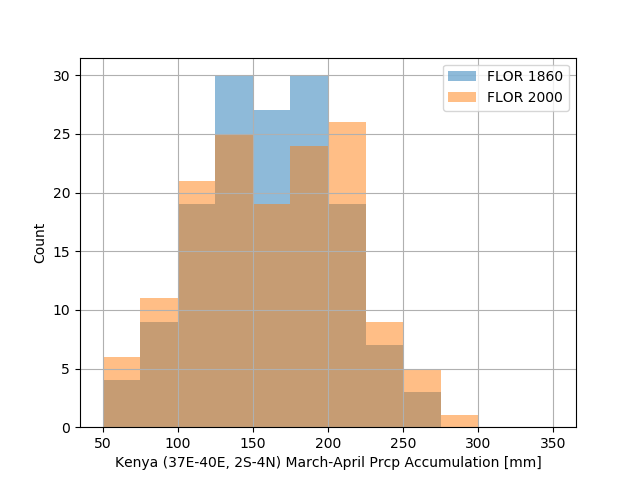

In [216]:
# plot
bins = range(50,350+1,25)
da = das['flor_1860_s']
da = da[(da['time.month']==3) | (da['time.month']==4)]
da.resample(time='AS').sum().plot.hist(label='FLOR 1860', bins=bins, alpha=.5)

da = das['flor_2000_s']
da = da[(da['time.month']==3) | (da['time.month']==4)]
da.resample(time='AS').sum().plot.hist(label='FLOR 2000', bins=bins, alpha=.5)

plt.grid(True)
plt.legend(frameon=True)
plt.xlabel('Kenya (37E-40E, 2S-4N) March-April Prcp Accumulation [mm]')
plt.savefig(fignames['accum_sbox'])

## 10-day mean

<IPython.core.display.Javascript object>


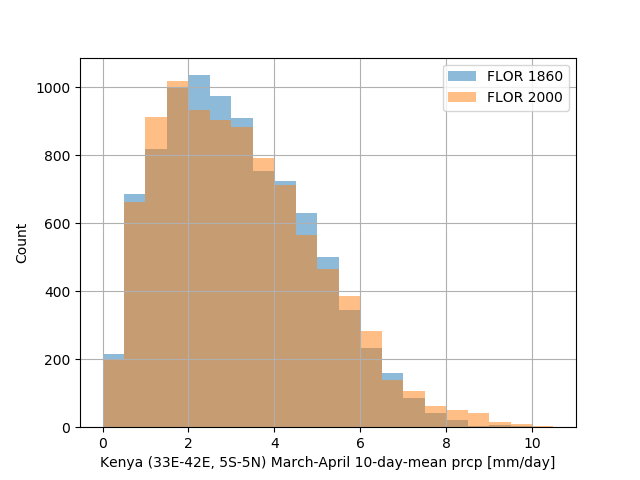

In [20]:
# plot
alpha = .5
bins = np.arange(0,11,.5)

da = das['flor_1860']
da = da.rolling(time=10).mean()
da = da[(da['time.month']==3) | (da['time.month']==4)]
# da = da.resample(time='AS').max()
da.plot.hist(alpha=alpha, label='FLOR 1860', bins=bins)

da = das['flor_2000']
da = da.rolling(time=10).mean()
da = da[(da['time.month']==3) | (da['time.month']==4)]
# da = da.resample(time='AS').max()
da.plot.hist(alpha=alpha, label='FLOR 2000', bins=bins)

# plt.axvline(7, color='k', ls='--')

plt.grid(True)
plt.legend(frameon=True)
plt.xlabel('Kenya (33E-42E, 5S-5N) March-April 10-day-mean prcp [mm/day]')
plt.savefig(fignames['rmean10'])

### small region box

<IPython.core.display.Javascript object>


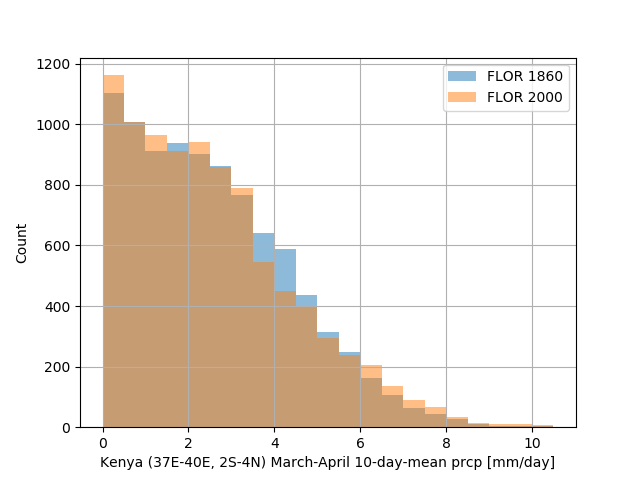

In [21]:
# plot: small region box
alpha = .5
bins = np.arange(0,11,.5)

da = das['flor_1860_s']
da = da.rolling(time=10).mean()
da = da[(da['time.month']==3) | (da['time.month']==4)]
# da = da.resample(time='AS').max('time')
da.plot.hist(alpha=alpha, label='FLOR 1860', bins=bins)

da = das['flor_2000_s']
da = da.rolling(time=10).mean()
da = da[(da['time.month']==3) | (da['time.month']==4)]
# da = da.resample(time='AS').max('time')
da.plot.hist(alpha=alpha, label='FLOR 2000', bins=bins)

# plt.axvline(7, color='k', ls='--')

plt.grid(True)
plt.legend(frameon=True)
plt.xlabel('Kenya (37E-40E, 2S-4N) March-April 10-day-mean prcp [mm/day]')
plt.savefig(fignames['rmean10_sbox'])